<h1>Fast Experimentation in Amazon SageMaker Studio Notebooks</h1>

In this notebok, you will perform data exploration and preprocessing using familiar libraries such as pandas and scikit-learn. You will then perform and track experiments and train a Machine Learning model using SageMaker Studio.

You will be using the "AI4I 2020 Predictive Maintenance Dataset" from the UCI Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset. You will use the dataset containing information about machine failures to train a binary classification model that predicts whether a machine will fail based on input data.

## Environment set up 

Let's start with the initial setup steps

In [2]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install sagemaker-experiments

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 768.8 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


Retreive information about the default session Amazon S3 bucket for storing training data, and the IAM role that provides the required permissions.

In [5]:
import sagemaker
import boto3
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker_session.default_bucket()
prefix = 'sm-fast-iteration'

print(region)
print(role)
print(bucket_name)

eu-west-1
arn:aws:iam::009319036446:role/service-role/AmazonSageMakerExecutionRole-mlendtoend-vpcmode-sagemaker
sagemaker-eu-west-1-009319036446


Download the dataset

In [6]:
import urllib
import os

data_dir = '/opt/ml/data'
if not os.path.exists(data_dir):
        os.makedirs(data_dir)
file_path = os.path.join(data_dir, 'predmain_raw_data_header.csv')
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
urllib.request.urlretrieve(dataset_url, file_path)

('/opt/ml/data/predmain_raw_data_header.csv',
 <http.client.HTTPMessage at 0x7f9a2a275a80>)

You can save the raw data to the default S3 bucket so that other AWS Services and notebooks have access to the data.

In [23]:
raw_data_key = '{0}/data/raw'.format(prefix)
s3_raw_data = sagemaker_session.upload_data(file_path,bucket_name,key_prefix=raw_data_key)

# Data Preprocessing & Feature Engineering

### Data Exploration

Take a look at the shape of our dataset

In [7]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(file_path)

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (10000, 14)


Now we know how many samples we have. Next, let's take a look at the records we have by printing the first 10 rows.

In [8]:
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0


We also want to check the data types for each column and identify any columns with missing values

In [9]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Let's try to see what are possible values for the field "Machine failure" and how frequently they occur over the entire dataset

In [10]:
df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

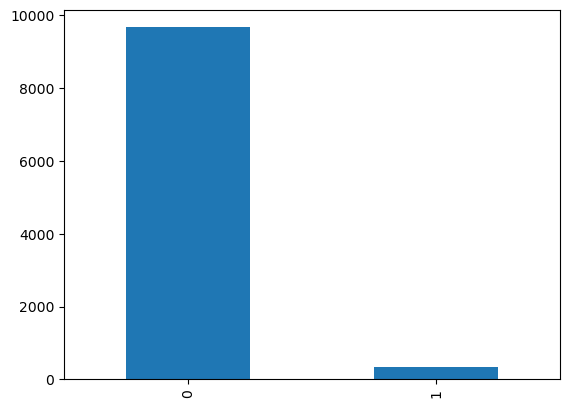

In [11]:
import matplotlib.pyplot as plt

df['Machine failure'].value_counts().plot.bar()
plt.show()

We have discovered that the dataset is quite unbalanced. However, we are not going to balance it in this workshop.

Drop the attributes you are not interested in and keep only the numeric attributes.

In [13]:
df1 = df.sample(frac =.1)
df1 = df1.drop(['UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1).select_dtypes(include='number')
df1.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
3706,302.0,311.3,1567,41.1,26,0
9871,298.9,309.8,1947,21.7,105,0
6949,300.7,311.2,1769,26.5,63,0
3465,301.8,310.7,1383,45.7,44,0
4608,303.0,311.2,1519,38.0,139,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

Use a pair plot to spot correlations.

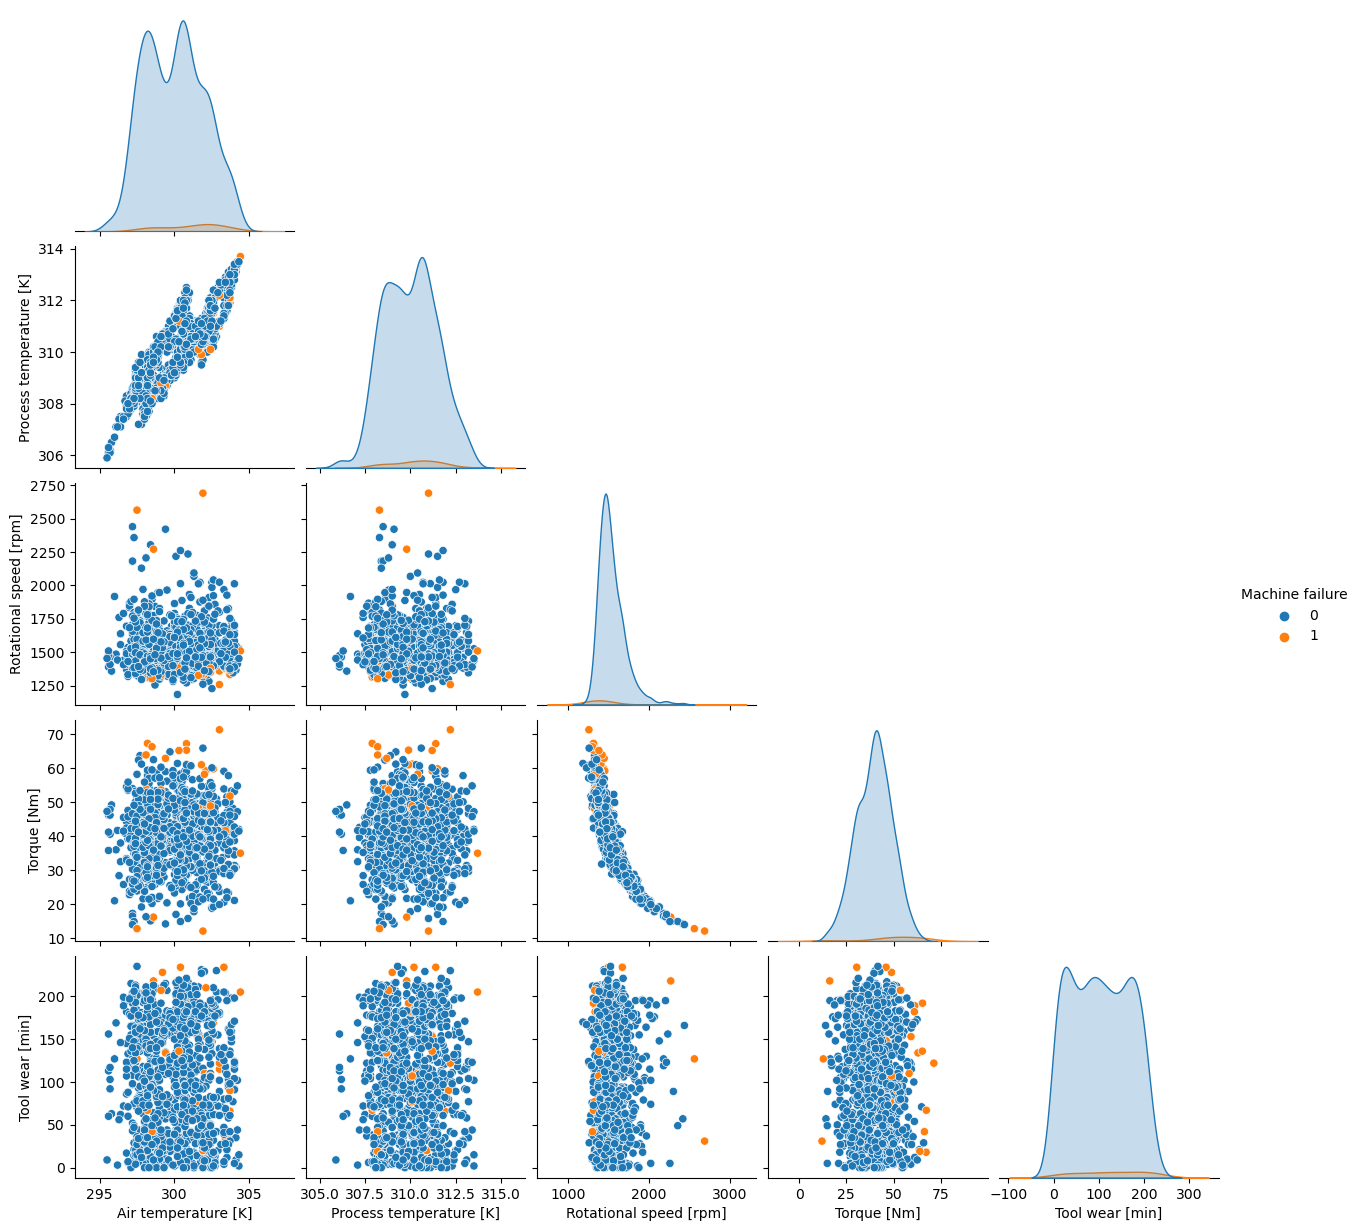

In [15]:
import seaborn
import matplotlib.pyplot as plt

seaborn.pairplot(df1, hue='Machine failure', corner=True)
plt.show()

To keep the data exploration step short during the workshop, no additional queries are included. However, feel free to explore the dataset more if you have time.

<h2>Preprocessing and Feature Engineering</h2>

### Experiment set up

Even though you are in the fast experimentation stage, it is still a good idea to track the experiments. You will leverage Amazon SageMaker Experiments to track the experimentations during training.

To do so, we need to create an _experiment_ and a new _trial_ for that experiment. A trial is a collection of training steps involved in a single training job such as preprocessing, training, model evaluation, etc. A trial contains also metadata for inputs (e.g. algorithm, parameters, data sets) and outputs (e.g. models, checkpoints, metrics). Each stage in a trial constitutes a trial component. If  you would like to read more about SageMaker experiments, see also https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html

Let's import our utility script, which will help us easily manage our experiments.

In [17]:
import sys
sys.path.append("source_dir")
from experimentutils import *

We begin with creating an experiment, or loading one if it already exists.

In [18]:
experiment_name = createExperiment("sm-fast-iteration-exp", "ML development and fast iteration with SageMaker")

Creating experiment sm-fast-iteration-exp-1677780922


From now on, we will use the above experiment to start tracking our processing and training trials. Let's create a new trial and associate it with our experiment.

In [19]:
trial_name = createTrial(experiment_name, "exp-tracking-trial-xgboost",prefix)
print(trial_name)

Creating trial, exp-tracking-trial-xgboost-1677780925
exp-tracking-trial-xgboost-1677780925


### Data Processing

We are now ready to continue the with data processing and feature engineering tasks. We will hot encode some of the categorical columns and fill in some NaN values based on domain knowledge. Once the SKLearn fit() and transform() are done, we split our dataset into train & validation and then save the outputs to Amazon S3. We will capture this step as the first trial component of our trial. For more details on the CreateTrialComponent API call, check out https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTrialComponent.html

In [20]:
output_path = "/opt/ml/processing"
model_path = "/opt/ml/model"

In [22]:
ratio = 0.1
%run -i source_dir/preprocessor.py --train-val-split-ratio $ratio --file-path $file_path --output-path $output_path --model-path $model_path  --s3-prefix $prefix

parameters={
            'ratio': {
                'NumberValue': ratio
            }
    }
process_trial_comp = createTrialComponent(trial_name,"trial-comp-preprocess", prefix, file_path, train_features_output_path, val_features_output_path, model_joblib_path, parameters)

/opt/ml/data/predmain_raw_data_header.csv
Splitting data into train and test sets with ratio 0.1
Train features shape after preprocessing: (7200, 8)
Validation features shape after preprocessing: (800, 8)
Testing features shape after preprocessing: (800, 8)
/opt/ml/processing
Saving to /opt/ml/processing/train_features.csv
Saving to /opt/ml/processing/train_labels.csv
Saving to /opt/ml/processing/val_features.csv
Saving to /opt/ml/processing/val_labels.csv
Saving to /opt/ml/processing/test_features.csv
Saving to /opt/ml/processing/test_labels.csv
Uploading to s3 at s3://sagemaker-eu-west-1-009319036446/sm-fast-iteration
Creating trial component trial-comp-preprocess-1677781045 for trial exp-tracking-trial-xgboost-1677780925


Let's also take a look at our processed training dataset.

In [24]:
import pandas as pd
df = pd.read_csv(train_features_output_path)
df.head(10)

,0.6490887153734223,0.8728195547539311,-0.3541272268333058,1.0697128067143444,-1.5398969143048868,0.0,1.0,0.0.1
0,1.148073,1.142552,-0.150273,-0.139907,0.503578,0.0,1.0,0.0
1,0.649089,0.805386,-0.557982,0.233059,-1.586694,0.0,0.0,1.0
2,-1.147255,-1.622208,1.741044,-1.833375,-0.744345,0.0,1.0,0.0
3,-0.997560,-1.554775,-0.733523,0.384262,1.501918,0.0,1.0,0.0
4,0.000409,0.940253,-0.342802,-0.109667,-0.260775,0.0,1.0,0.0
5,0.150104,1.007686,-0.773162,0.374181,-1.695887,0.0,0.0,1.0
6,1.447464,1.547151,-0.037020,-0.522953,1.189937,0.0,1.0,0.0
7,-1.446646,-1.150176,-0.229549,0.575785,1.267932,0.0,1.0,0.0
8,0.449495,0.265921,0.138521,-0.744717,-0.650751,0.0,1.0,0.0
9,1.148073,0.603087,2.816943,-2.055139,1.267932,0.0,1.0,0.0


We can see that the categorical variables have been one-hot encoded, and you are free to check that we do not have NaN values anymore as expected.


### Experiment Analytics

We can visualize the experiment analytics either from Amazon SageMaker Studio Experiments plug-in or using the sagemaker SDK as per below.

In [25]:
from sagemaker.analytics import ExperimentAnalytics
experiment = ExperimentAnalytics(experiment_name=experiment_name)
experiment.dataframe()

,TrialComponentName,DisplayName,ratio,input_data - MediaType,input_data - Value,model - MediaType,model - Value,train_data - MediaType,train_data - Value,val_data - MediaType,val_data - Value,Trials,Experiments
0,trial-comp-preprocess-1677781045,trial-comp-preprocess-1677781045,0.1,text/csv,/opt/ml/data/predmain_raw_data_header.csv,text/plain,/opt/ml/model/model.joblib,text/csv,/opt/ml/processing/train_features.csv,text/csv,/opt/ml/processing/val_features.csv,[exp-tracking-trial-xgboost-1677780925],[sm-fast-iteration-exp-1677780922]


## Model Training

In this part, we will use xgboost to train a simple binary classification model, using the pre-processed data generated in the previous step by the processing job. We will create a new trial component each time we start the training and will record the hyperparameter values and the results.

In [26]:
eta = 0.3
%run -i source_dir/xgboost_training.py --eta $eta
parameters={
            'eta': {
                'NumberValue': eta
            }
}
training_trial_comp = createTrialComponent(trial_name,"trial-comp-xgboost",prefix, file_path, 
                                           train_features_output_path, val_features_output_path, model_path, parameters)


Received arguments Namespace(local_data_path='/opt/ml/processing', max_depth=3, eta=0.3, gamma=0.0, min_child_weight=1, verbosity=0, objective='binary:logistic', eval_metric='auc', num_boost_round=5)
Loading training data...
Loading validation data...
Train features shape: (7200, 8)
Train labels shape: (7200,)
Validation features shape: (800, 8)
Validation labels shape: (800,)
Starting new trial: exp-tracking-trial-xgboost-1677780925
Starting training...
[0]	train-auc:0.80459	validation-auc:0.73976
[1]	train-auc:0.92266	validation-auc:0.92837
[2]	train-auc:0.94566	validation-auc:0.92760
[3]	train-auc:0.96810	validation-auc:0.96210
[4]	train-auc:0.97005	validation-auc:0.96057
Training complete. Saving model...
===Metrics for Validation Set===

Predictions  0.0  1.0  All
Actuals                   
0            772    1  773
1             23    4   27
All          795    5  800


Accuracy Model A: 97.00%
Precision Model A: 0.80
Recall Model A: 0.85
AUC A: 0.96
Creating trial component tri

### Experiment analytics

Again, you can visualize your latest experiment analytics either from Amazon SageMaker Studio Experiments plug-in or using the SDK from a notebook

In [31]:
from sagemaker.analytics import ExperimentAnalytics
experiment = ExperimentAnalytics(experiment_name=experiment_name)
experiment.dataframe()

,TrialComponentName,DisplayName,eta,input_data - MediaType,input_data - Value,model - MediaType,model - Value,train_data - MediaType,train_data - Value,val_data - MediaType,val_data - Value,Trials,Experiments,ratio
0,trial-comp-xgboost-1677781132,trial-comp-xgboost-1677781132,0.3,text/csv,/opt/ml/data/predmain_raw_data_header.csv,text/plain,/opt/ml/model/xgboost_model_1677781132.model,text/csv,/opt/ml/processing/train_features.csv,text/csv,/opt/ml/processing/val_features.csv,[exp-tracking-trial-xgboost-1677780925],[sm-fast-iteration-exp-1677780922],NaN
1,trial-comp-preprocess-1677781045,trial-comp-preprocess-1677781045,NaN,text/csv,/opt/ml/data/predmain_raw_data_header.csv,text/plain,/opt/ml/model/model.joblib,text/csv,/opt/ml/processing/train_features.csv,text/csv,/opt/ml/processing/val_features.csv,[exp-tracking-trial-xgboost-1677780925],[sm-fast-iteration-exp-1677780922],0.1


### Using your model to generate predictions

Let's now use our model for inference.

In [28]:
df_test_features = pd.read_csv(test_features_output_path, header=None)
df_test_labels = pd.read_csv(train_labels_output_path, header=None)
test_X = df_test_features.values
test_y = df_test_labels.values.reshape(-1)
dtest = xgboost.DMatrix(test_X, label=test_y)

model_xgb_trial = xgboost.Booster()
model_xgb_trial.load_model(model_path)
test_predictions = model_xgb_trial.predict(dtest)

In [29]:
print ("===Metrics for Test Set===")
print('')
print (pd.crosstab(index=test_y, columns=np.round(test_predictions), 
                                 rownames=['Actuals'], 
                                 colnames=['Predictions'], 
                                 margins=True)
      )
print('')
rounded_predict = np.round(test_predictions)

accuracy = accuracy_score(test_y, rounded_predict)
precision = precision_score(test_y, rounded_predict)
recall = recall_score(test_y, rounded_predict)
print('')

print("Accuracy Model A: %.2f%%" % (accuracy * 100.0))
print("Precision Model A: %.2f" % (precision))
print("Recall Model A: %.2f" % (1 - recall))

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_y, test_predictions)
print("AUC A: %.2f" % (auc))

===Metrics for Test Set===

Predictions   0.0  1.0   All
Actuals                     
0            1929    3  1932
1              46   22    68
All          1975   25  2000


Accuracy Model A: 97.55%
Precision Model A: 0.88
Recall Model A: 0.68
AUC A: 0.94



As SageMaker Experiments now supports common chart types to visualize model training results, we can track these granular metrics to our experiments.

In [30]:
import smexperiments
from smexperiments.tracker import Tracker
 
with Tracker.load(trial_component_name=training_trial_comp) as tracker:
    tracker.log_precision_recall(test_y, rounded_predict)
    tracker.log_roc_curve(test_y, rounded_predict)
    tracker.log_confusion_matrix(test_y, rounded_predict)

### Clean up step (Optional)

In [ ]:
#  cleanup('ENTER_YOUR_EXPERIMENT_HERE')